In [14]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import math

hpi_red = '#b00639'
hpi_blue = '#007a9e'
hpi_yellow = '#ffde94'

def create_folder(filename):
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def save_plot(filename):
    filename = filename.replace(" ", "_").replace(":", "_").replace(".", "_") \
                       .replace(",", "_").replace("\n", "_").replace("__", "_").lower()
    create_folder("plots/table_scan/")
    plt.savefig('plots/table_scan/{}.pgf'.format(filename))
    plt.savefig('plots/table_scan/{}.pdf'.format(filename))
    
def get_column_names(benchmark): 
    filename = "results/" + benchmark + '_results.csv.json'
    table_info = json.load(open(filename,'r'))
    #print(json.dumps(table_info, indent=2, sort_keys=False))
    column_names = []
    for column in table_info["columns"]:
        column_names.append(column["name"])
    return column_names
    
def get_results(benchmark):
    filename = "results/" + benchmark + '_results.csv'
    return pd.read_csv(filename, header=None, names=get_column_names(benchmark))

def microseconds(x, pos):
    'The two args are the value and tick position'
    return '%i' % x
 
def milliseconds(x, pos):
    return '%i' % (x*1e-3)

def kilobytes(x, pos):
    return '%i' % x

def megabytes(x, pos):
    return '%i' % (x*1e-3)

def plot_all_groups():
    group_columns = get_column_names('custom')
    group_columns.remove('remainder_size')
    group_columns.remove('size')
    group_columns.remove('run_time')
    grouped_data = get_results('custom').groupby(group_columns)
    for group_info in list(grouped_data.groups):
        for i in range(0, len(group_columns)):
            print(group_columns[i] + ": " + str(group_info[i]))
        sub_groups = grouped_data.get_group(group_info).groupby('remainder_size')
        run_time_data = []
        for remainder_size in list(sub_groups.groups):
            run_time_data.append(sub_groups.get_group(remainder_size)['run_time']) 
        plot_labels = ['None', '2', '4', '8', '16'][0:len(run_time_data)]
        boxplot('Table Scan Runtime', run_time_data, plot_labels)
        
def memory_bar(base_sizes, additional_sizes, title, subtitle, labels, file_name):
    sizes = base_sizes + additional_sizes
    size_formatter = FuncFormatter(megabytes)
    unit = "MB"
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(size_formatter)
    plt.rc('xtick', labelsize=11) 
    ax.set_title(title + " Memory Consumption" + '\n' + subtitle)
    ax.yaxis.grid()
    ax.set_axisbelow(True)
    plt.ylabel("Memory Consumption [{}]".format(unit))
    y_step = max(sizes) / 10
    #plt.yticks(np.arange(0, max(sizes)*1.1, y_step))
    plt.ylim(0, max(sizes)*1.4)
    edgecolors = ['black'] * len(sizes)
    bar1 = plt.bar(range(len(base_sizes)), base_sizes, width=1/1.5, color=hpi_red, tick_label=labels, linewidth=1.0, \
            edgecolor=edgecolors, label="Column Data")
    bar2 = plt.bar(range(len(additional_sizes)), additional_sizes, bottom=base_sizes, width=1/1.5, color=hpi_yellow, \
            tick_label=labels, linewidth=1.0, edgecolor=edgecolors, label="Filter/Index")
    plt.legend(handles=[bar2, bar1])
    
    def autolabel(rects1, rects2):
        """
        Attach a text label above each bar displaying its height
        """
        for i in range(0, len(rects1)):
            rect1 = rects1[i]
            rect2 = rects2[i]
            rect = rect1
            height = rect1.get_height() + rect2.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 0.03 * max(sizes),'%d' % int(height), ha='center', va='bottom')

    autolabel(bar1, bar2)

    save_plot(file_name + "_memory")
    plt.show()
    
def memory_bar_full(value, interval_map, value_filter, dictionary, art, btree, title, subtitle, file_name): 
    value_size = value['size'].iloc[0]
    value_filter_size = value_filter['size'].iloc[0]
    dict_size = dictionary['size'].iloc[0]
    art_size = art['size'].iloc[0]
    btree_size = btree['size'].iloc[0]
    interval_size = interval_map['size'].iloc[0]
        
    base_sizes = [value_size, value_size, value_size, dict_size, dict_size, value_size]
    additional_sizes = [0, interval_size - value_size, value_filter_size - value_size, 0, art_size - dict_size, btree_size - value_size]
    
    labels = ['Value\nColumn', 'Value +\nInterval Map', 'Value +\nFilter', 'Dictionary\nColumn', 'ART', 'B-Tree']
    memory_bar(base_sizes, additional_sizes, title, subtitle, labels, file_name)
    
def memory_bar_small(value, interval_map, value_filter, title, subtitle, file_name):
    value_size = value['size'].iloc[0]
    value_filter_size = value_filter['size'].iloc[0]
    interval_size = interval_map['size'].iloc[0]

    base_sizes = [value_size, value_size, value_size]
    additional_sizes = [0, interval_size - value_size, value_filter_size - value_size]
    
    labels = ['Value\nColumn', 'Value +\nInterval Map', 'Value +\nFilter']
    memory_bar(base_sizes, additional_sizes, title, subtitle, labels, file_name)
    
def runtime_bar(title, subtitle, data, labels, file_name, unit='milli', start_at_zero=True):
    runtimes = []
    for series in data:
        runtimes.append(np.median(series['run_time']))
    
    formatter = FuncFormatter(microseconds)
    unit_symbol = "ms"
    if unit == 'milli':
        formatter = FuncFormatter(milliseconds)
        unit_symbol = "ms"
    elif unit == 'micro':
        formatter = FuncFormatter(microseconds)
        unit_symbol = "µs"
    else: 
        print('unknown unit')

    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(formatter)
    plt.rc('xtick', labelsize=11) 
    ax.yaxis.grid()
    ax.set_axisbelow(True)
    edgecolors = ['black'] * len(runtimes)
    plt.bar(range(len(runtimes)), runtimes, width=1/1.5, color=hpi_blue, tick_label=labels, linewidth=1.0, edgecolor=edgecolors)
    
    #bp_dict = plt.boxplot(data, labels=labels, showfliers=False)
    #for line in bp_dict['medians']:
    #    # get position data for median line
    #    print(line)
    #    x, y = line.get_xydata()[1] # top of median line
    #    # overlay median value
    #    plt.text(x, y - 100, '%d' % y, horizontalalignment='center') # draw above, centered
    
    plt.title(title + " Runtime" + '\n' + subtitle)
    #plt.xlabel('remainder size')
    plt.ylabel('Runtime [{}]'.format(unit_symbol))
    if start_at_zero:
        ax.set_ylim(ymin=0)
    save_plot(file_name + "_runtime")
    plt.show()
    
def runtime_box(title, subtitle, data, labels, file_name, unit='milli', start_at_zero=True): 
    runtimes = []
    for series in data:
        runtimes.append(series['run_time'])
    
    formatter = FuncFormatter(microseconds)
    unit_symbol = "ms"
    if unit == 'milli':
        formatter = FuncFormatter(milliseconds)
        unit_symbol = "ms"
    elif unit == 'micro':
        formatter = FuncFormatter(microseconds)
        unit_symbol = "µs"
    else: 
        print('unknown unit')

    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(formatter)
    plt.rc('xtick', labelsize=8) 
    ax.yaxis.grid()
    ax.set_axisbelow(True)
    plt.boxplot(runtimes, labels=labels, showfliers=False)
    
    #bp_dict = plt.boxplot(data, labels=labels, showfliers=False)
    #for line in bp_dict['medians']:
    #    # get position data for median line
    #    print(line)
    #    x, y = line.get_xydata()[1] # top of median line
    #    # overlay median value
    #    plt.text(x, y - 100, '%d' % y, horizontalalignment='center') # draw above, centered
    
    plt.title(title + " Runtime" + "\n" + subtitle)
    #plt.xlabel('remainder size')
    plt.ylabel('Runtime [{}]'.format(unit_symbol))
    if start_at_zero:
        ax.set_ylim(ymin=0)
    save_plot(file_name + "_runtime")
    plt.show()

#table_name
#column_name
#data_type
#row_count
#chunk_size
#pruning_rate
#selectivity
#quotient_size
#remainder_size
#dictionary
#interval_map
#btree
#art
#size
#run_time

def select(data, table_name=None, column_name=None, data_type=None, row_count=None, chunk_size=None, \
           quotient_size=None, remainder_size=None, dictionary=None, interval_map=None, btree=None, art=None, \
           pruning_rate=None, selectivity=None):
    if table_name == None:
        table_name = data["table_name"].iloc[0]
    if column_name == None:
        column_name = data["column_name"].iloc[0]
    if data_type == None:
        data_type = data["data_type"].iloc[0]
    if row_count == None:
        row_count = data["row_count"].iloc[0]
    if chunk_size == None:
        chunk_size = data["chunk_size"].iloc[0]
    if quotient_size == None:
        quotient_size = data["quotient_size"].iloc[0]
    if remainder_size == None:
        remainder_size = data["remainder_size"].iloc[0]
    if dictionary == None:
        dictionary = data["dictionary"].iloc[0]
    if interval_map == None:
        interval_map = data["interval_map"].iloc[0]
    if btree == None:
        btree = data["btree"].iloc[0]
    if art == None:
        art = data["art"].iloc[0]
    if pruning_rate == None:
        pruning_rate = data["pruning_rate"].iloc[0]
    if selectivity == None:
        selectivity = data["selectivity"].iloc[0]
        
    return data[(data.table_name == table_name) &
                (data.column_name == column_name) &
                (data.data_type == data_type) &
                (data.row_count == row_count) &
                (data.chunk_size == chunk_size) &
                (data.quotient_size == quotient_size) & 
                (data.remainder_size == remainder_size) & 
                (data.dictionary == dictionary) & 
                (data.interval_map == interval_map) & 
                (data.btree == btree) & 
                (data.art == art) &
                (data.pruning_rate == pruning_rate) & 
                (data.selectivity == selectivity)
                ]
def btree(data):
    return select(data, remainder_size=0, dictionary=0, interval_map=0, btree=1, art=0)

def art(data):
    return select(data, remainder_size=0, dictionary=1, interval_map=0, btree=0, art=1)

def value(data):
    return select(data, remainder_size=0, dictionary=0, interval_map=0, btree=0, art=0)

def value_filter(data):
    return select(data, remainder_size=4, dictionary=0, interval_map=0, btree=0, art=0)

def dictionary(data):
    return select(data, remainder_size=0, dictionary=1, interval_map=0, btree=0, art=0)

def interval_map(data):
    return select(data, remainder_size=0, dictionary=0, interval_map=1, btree=0, art=0)

def dict_filter(data):
    return select(data, remainder_size=4, dictionary=1, interval_map=0, btree=0, art=0)

def evaluate_bar(data_name, data, column_name=None):
    if column_name == None:
        column_name = data['column_name'].iloc[0]
    data = data[data.column_name == column_name]
    
    #print(data)
        
    btree_data        = btree(data)
    art_data          = art(data)
    value_filter_data = value_filter(data)
    dictionary_data   = dictionary(data)
    interval_map_data = interval_map(data)
    dict_filter_data  = dict_filter(data)
    value_column_data = value(data)

    plot_data1 = [value_column_data, interval_map_data, value_filter_data, dictionary_data, art_data, btree_data]
    plot_data2 = [value_column_data, interval_map_data, value_filter_data]
    labels1 = ['Value\nColumn', 'Value +\nInterval Map', 'Value +\nFilter', 'Dictionary\nColumn', 'ART', 'B-Tree']
    labels2 = ['Value\nColumn', 'Value +\nInterval Map', 'Value +\nFilter']
    
    chunk_size = data['chunk_size'].iloc[0]
    row_count = data['row_count'].iloc[0]
    table_name = data['table_name'].iloc[0]
    
    title = table_name + '::' + column_name
    subtitle = 'Chunk Size: {:,}, Row Count: {:,}'.format(chunk_size, row_count)
    memory_bar_full(*plot_data1, title, subtitle, data_name + "_" + column_name + "_scan_bar_full")
    runtime_bar(title, subtitle, plot_data1, labels1, data_name + "_" + column_name + "_scan_bar_full")
    
    memory_bar_small(*plot_data2, title, subtitle, data_name + "_" + column_name + "_scan_bar_small")
    runtime_bar(title, subtitle, plot_data2, labels2, data_name + "_" + column_name + "_scan_bar_small")
    
def evaluate_box(data_name, data, column_name=None):
    if column_name == None:
        column_name = data['column_name'].iloc[0]    
    data = data[data.column_name == column_name]
        
    btree_data        = btree(data)
    art_data          = art(data)
    value_filter_data = value_filter(data)
    dictionary_data   = dictionary(data)
    interval_map_data = interval_map(data)
    dict_filter_data  = dict_filter(data)
    value_column_data = value(data)
    
    plot_data1 = [value_column_data, interval_map_data, value_filter_data, dictionary_data, art_data, btree_data]
    plot_data2 = [value_column_data, interval_map_data, value_filter_data]
    labels1 = ['Value\nColumn', 'Value +\nInterval Map', 'Value +\nFilter', 'Dictionary\nColumn', 'ART', 'B-Tree']
    labels2 = ['Value\nColumn', 'Value +\nInterval Map', 'Value +\nFilter']
    
    table_name = data['table_name'].iloc[0]
    chunk_size = data['chunk_size'].iloc[0]
    row_count = data['row_count'].iloc[0]
    
    title = table_name + '::' + column_name
    subtitle = 'Chunk Size: {:,}, Row Count: {:,}'.format(chunk_size, row_count)
    
    memory_bar_full(*plot_data1, title, subtitle, data_name + "_" + column_name + "_scan_bar_full")
    runtime_box(title, subtitle, plot_data1, labels1, data_name + "_" + column_name + "_scan_box_full")
    memory_bar_small(*plot_data2, title, subtitle, data_name + "_" + column_name + "_scan_bar_small")
    runtime_box(title, subtitle, plot_data2, labels2, data_name + "_" + column_name + "_scan_box_small")
    
def filter_comparison(data_name, data, dictionary, filename="", column_name=None):
    plot_data = []
    base_sizes = []
    additional_sizes = []
    if column_name == None:
        column_name = data['column_name'].iloc[0]
    data = data[data.column_name == column_name]
    column_size = select(data, remainder_size=0, dictionary=int(dictionary), interval_map=0, btree=0, art=0)['size'].iloc[0]
    for remainder_size in [0, 2, 4, 8]:
        series = select(data, remainder_size=remainder_size, dictionary=int(dictionary), interval_map=0, btree=0, art=0)
        plot_data.append(series)
        base_sizes.append(column_size)
        additional_sizes.append(series['size'].iloc[0] - column_size)
    labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
    data_type = data['data_type'].iloc[0]
    chunk_size = data['chunk_size'].iloc[0]
    row_count = data['row_count'].iloc[0]
    column_type = "Value"
    if dictionary:
        column_type = "Dictionary"
    title = data_name.title() + " " + column_name + " Column Scan"
    subtitle = 'Chunk Size: {:,}, Row Count: {:,}'.format(chunk_size, row_count)
    full_filename = data_name + "_" + column_name + "_filter_comparison_" + "_" + column_type + "_" + filename
    memory_bar(base_sizes, additional_sizes, title, subtitle, labels, full_filename)
    runtime_box(title, subtitle, plot_data, labels, full_filename)
    
def chunk_size_comparison(data_name, data, column_name=None):
    if column_name == None:
        column_name = data['column_name'].iloc[0]
    data = data[data.column_name == column_name]
    chunk_sizes = data.chunk_size.unique().tolist()
    log_sizes = [3, 3.5, 4, 4.5, 5, 5.5, 6]
    value_data_series = []
    filter_data_series = []
    pruning_rate_series = []
    for chunk_size in chunk_sizes:
        quotient_size = math.ceil(math.log(chunk_size, 2))
        value_data_series.append( \
            select(data, chunk_size=chunk_size, quotient_size=quotient_size, remainder_size=0)["run_time"].mean())
        filter_data_series.append( \
            select(data, chunk_size=chunk_size, quotient_size=quotient_size, remainder_size=16)["run_time"].mean())
        pruning_rate_series.append( \
            select(data, chunk_size=chunk_size, quotient_size=quotient_size, remainder_size=16)["actual_pruning_rate"].mean())
    row_count = data['row_count'].iloc[0]
    title = data_name.title() + " chunk sizes and scan runtime"
    subtitle = "Row Count: {:,}".format(row_count)
    full_filename = data_name + "_chunk_size_comparison"

    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(FuncFormatter(milliseconds))
    unit = "ms"
    plt.ylabel('Runtime [{}]'.format(unit))
    plt.xlabel('log_10(Chunk Size)')
    plt.title('Table Scan Runtime')
    ax.grid()
    bar1 = plt.plot(log_sizes, value_data_series, "x-", color=hpi_red, label="VC Scan")
    bar2 = plt.plot(log_sizes, filter_data_series, "x-", color=hpi_blue, label="VC + Filter Scan" )
    plt.legend()
    save_plot(data_name + "_" + column_name + "_chunk_size_comparison_runtime")
    plt.show()
    
    #fig, ax = plt.subplots()
    #ax.yaxis.set_major_formatter(FuncFormatter(milliseconds))
    #plt.title('Table Scan Runtime - Only Value Columns')
    #plt.ylabel('Runtime')
    #plt.xlabel('log_10(Chunk Size)')
    #plt.plot(log_sizes, value_data_series, "x-", color=hpi_blue, label="Actual Counts")
    #plt.show()
    
    fig, ax = plt.subplots()
    #ax.yaxis.set_major_formatter(FuncFormatter(milliseconds))
    ax.grid()
    plt.title('Pruning Rates')
    plt.ylabel('Pruning Rate')
    plt.xlabel('log_10(Chunk Size)')
    ax.set_ylim(ymin=0, ymax=1.0)
    bar1 = plt.plot(log_sizes, pruning_rate_series, "x-", color=hpi_red, label="Pruning Rate")
    plt.legend()
    save_plot(data_name + "_" + column_name + "_chunk_size_comparison_pruning_rate")
    plt.show()
    

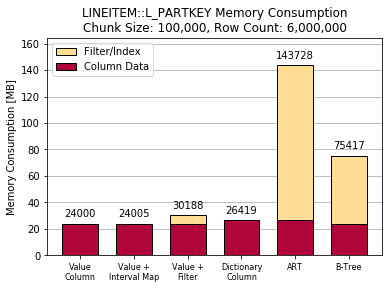

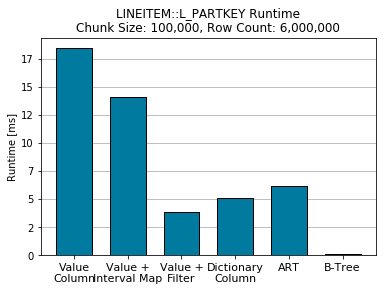

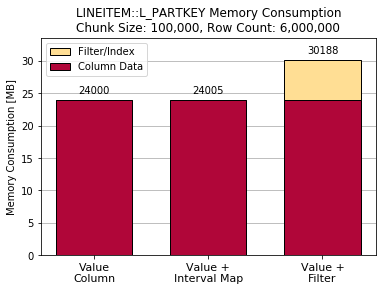

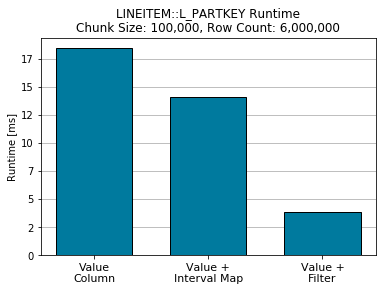

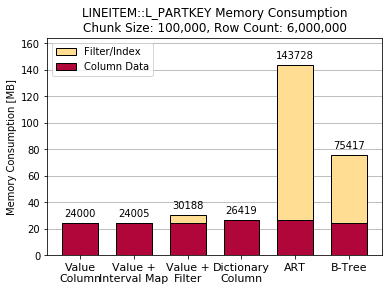

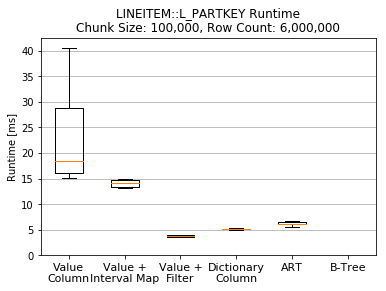

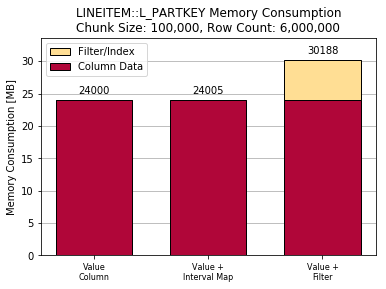

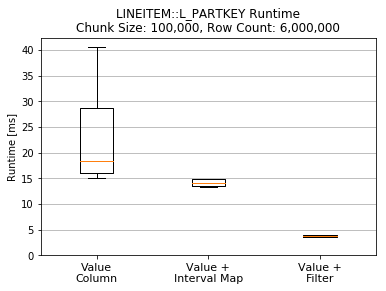

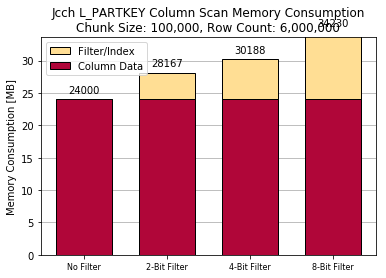

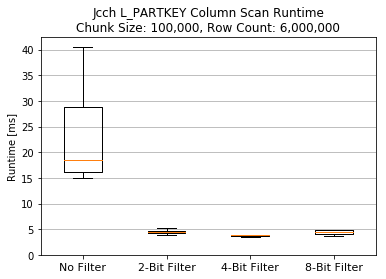

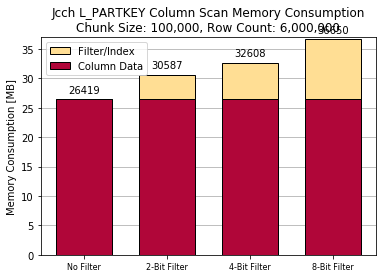

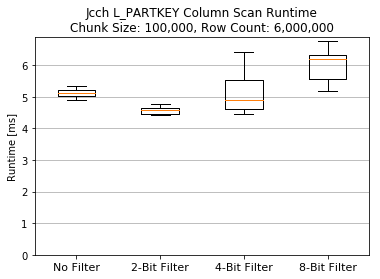

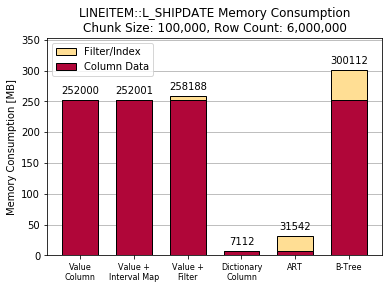

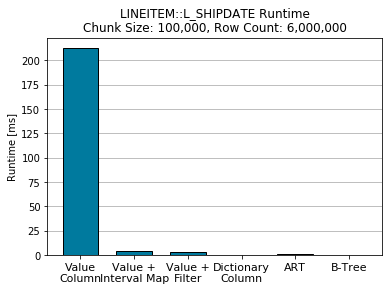

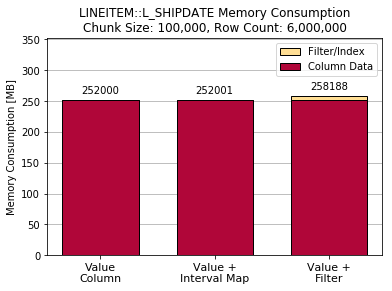

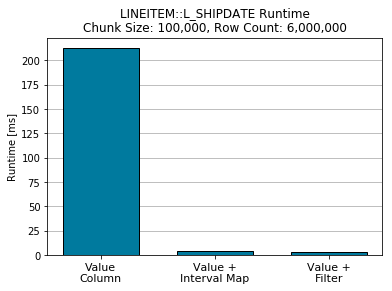

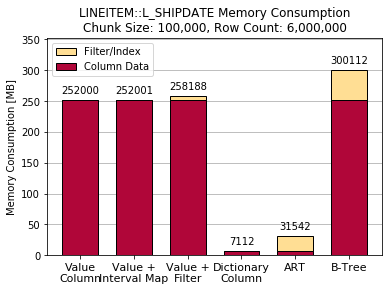

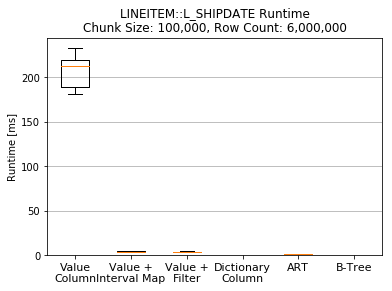

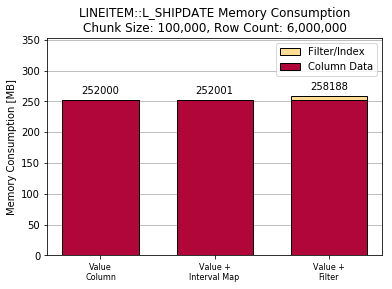

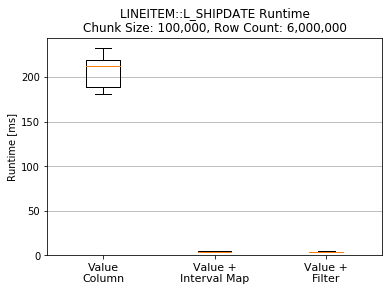

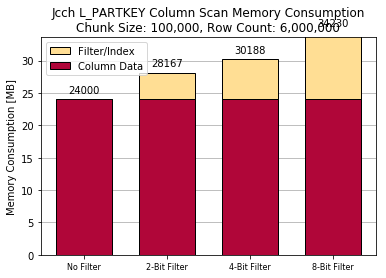

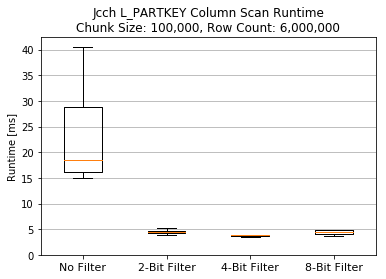

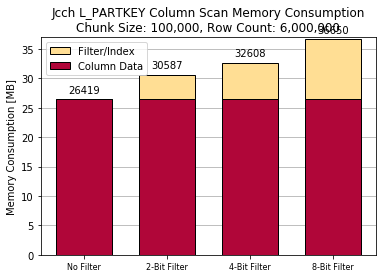

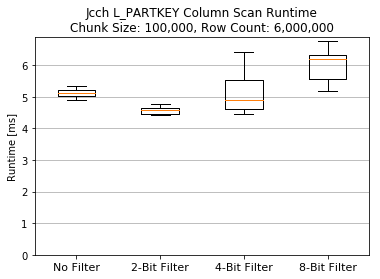

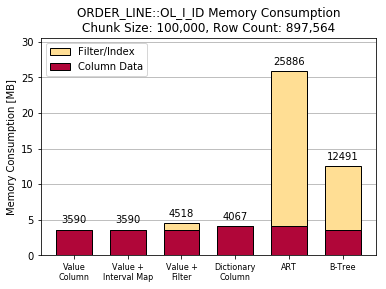

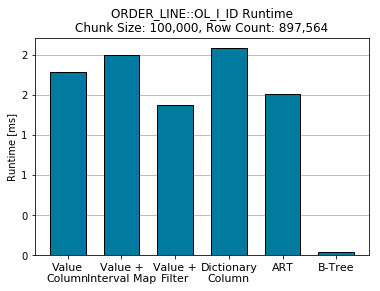

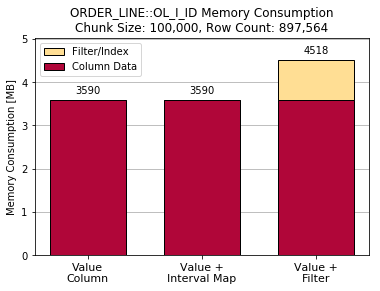

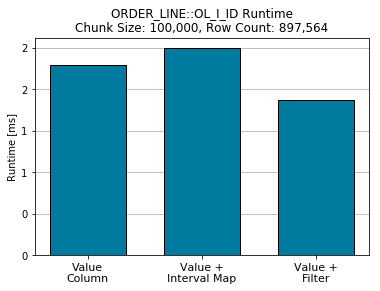

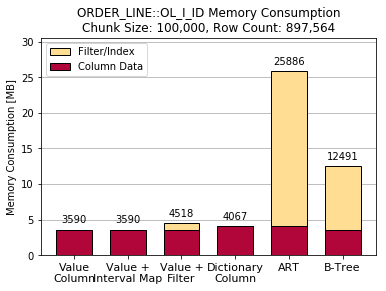

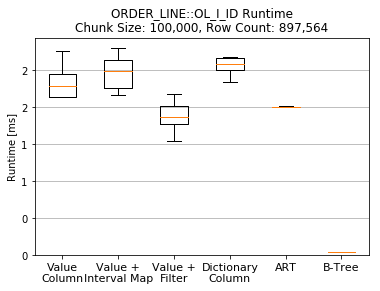

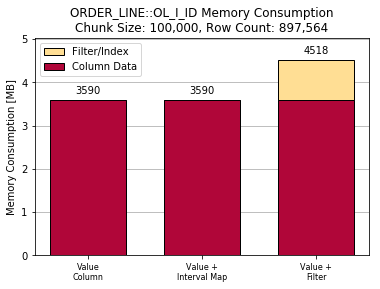

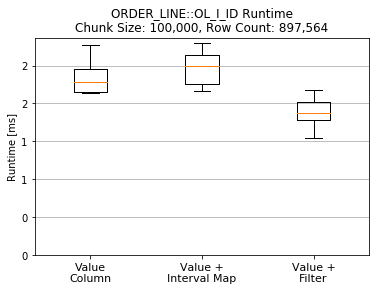

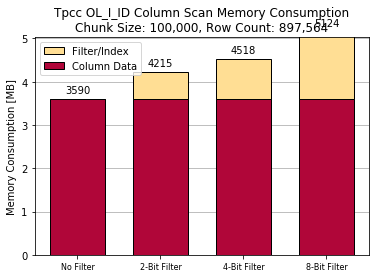

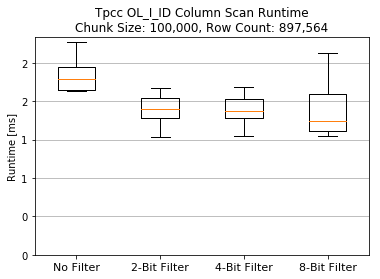

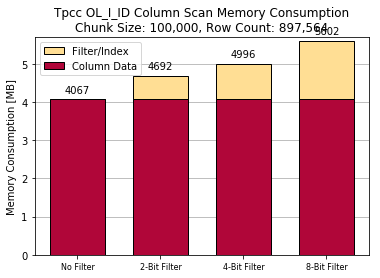

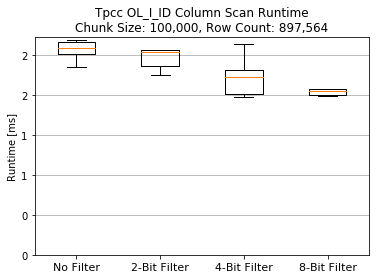

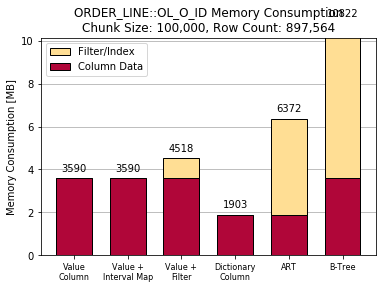

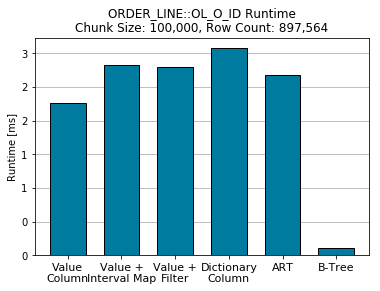

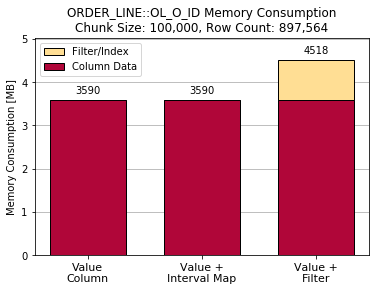

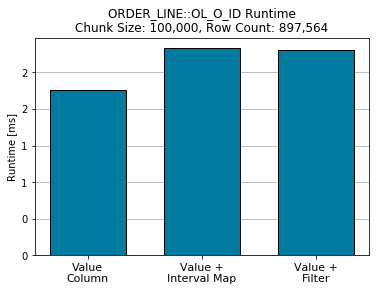

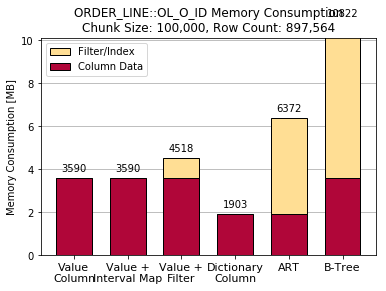

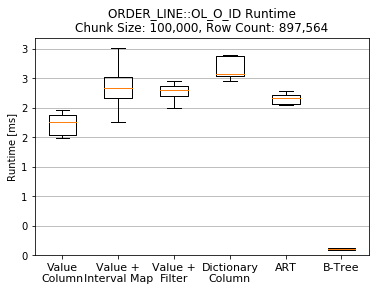

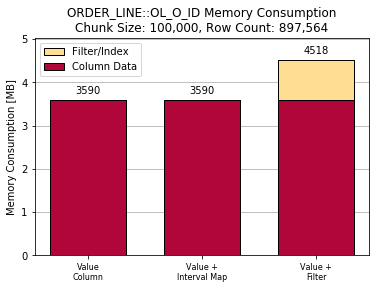

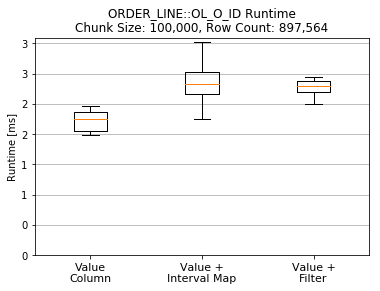

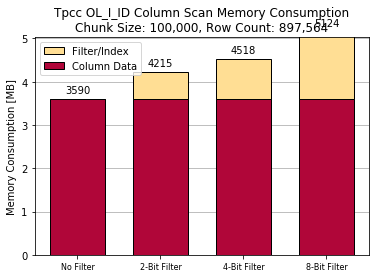

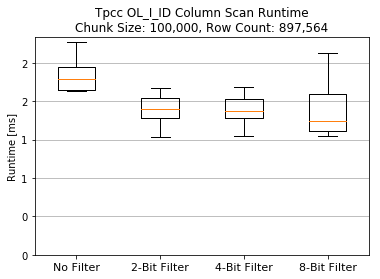

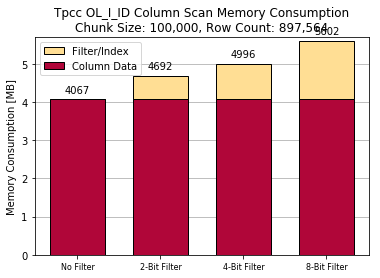

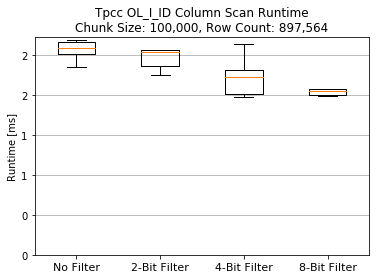

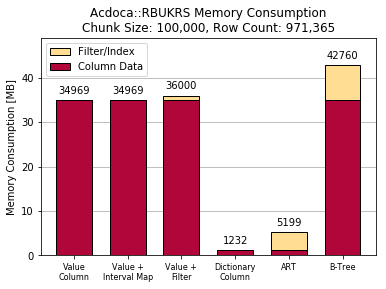

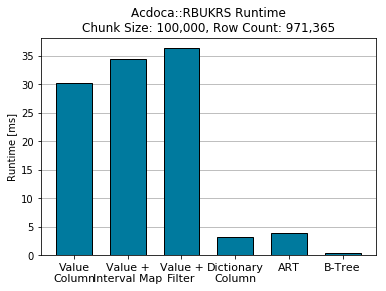

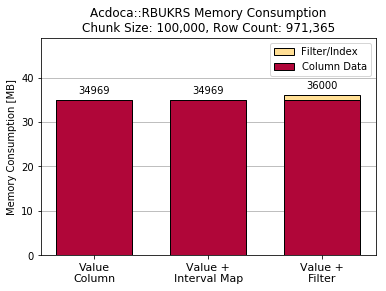

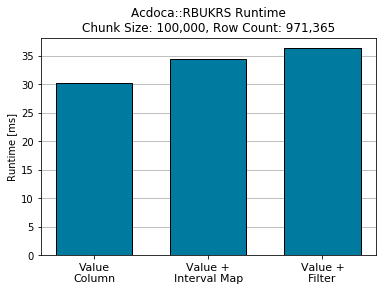

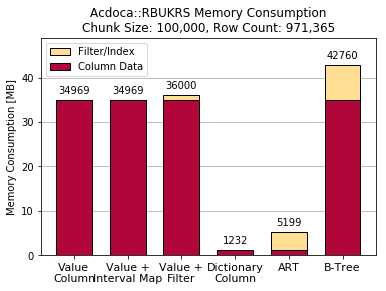

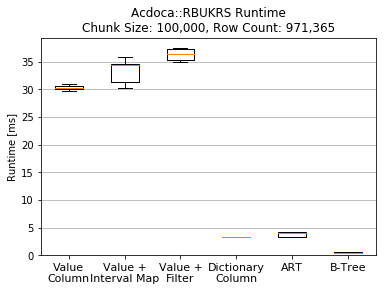

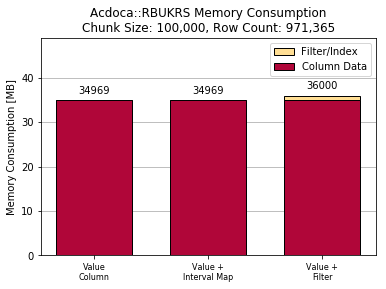

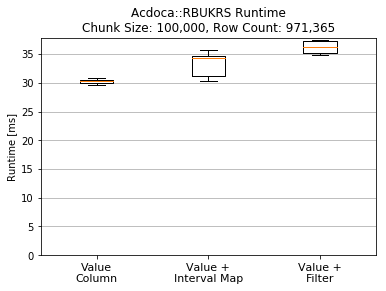

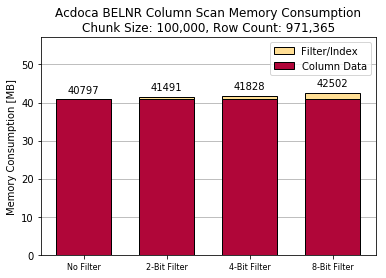

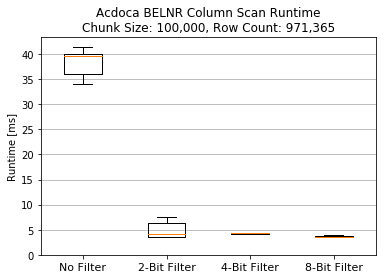

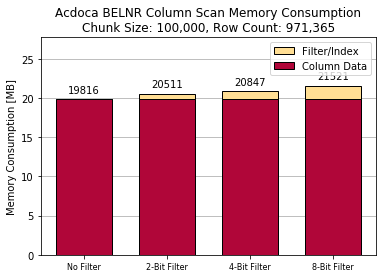

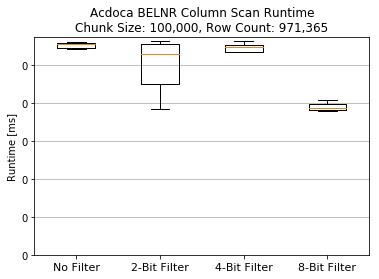

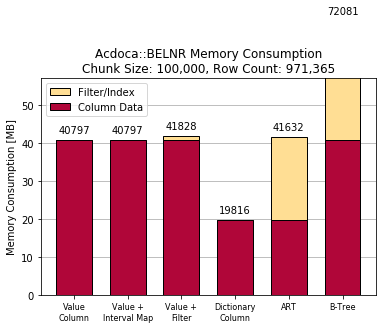

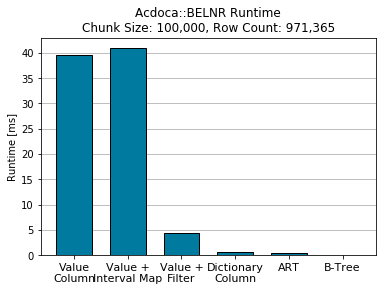

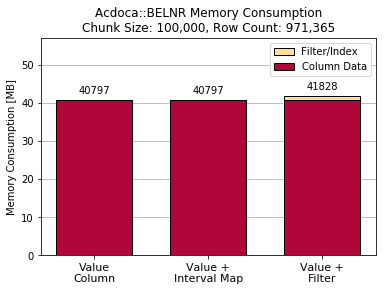

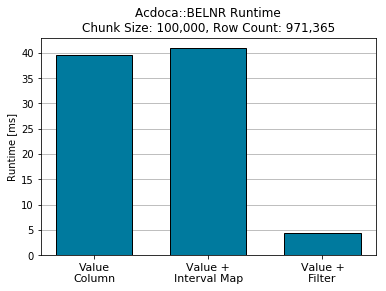

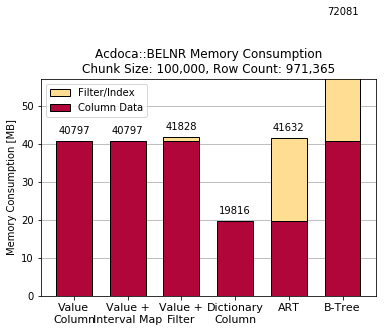

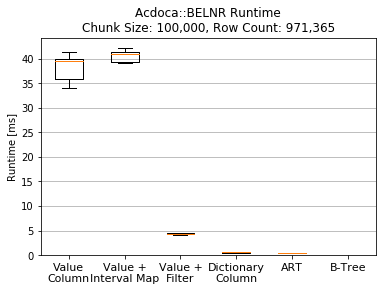

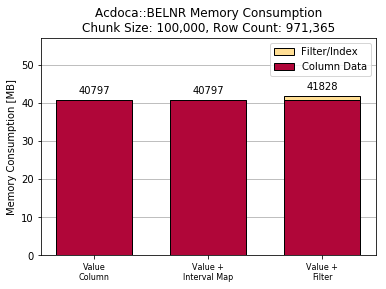

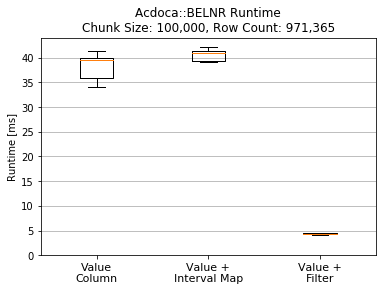

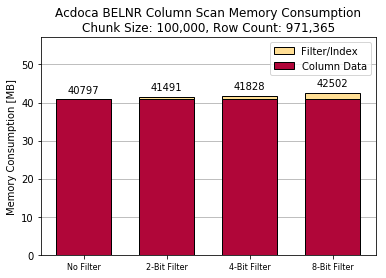

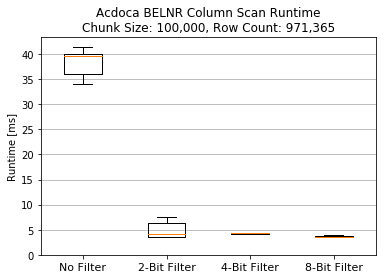

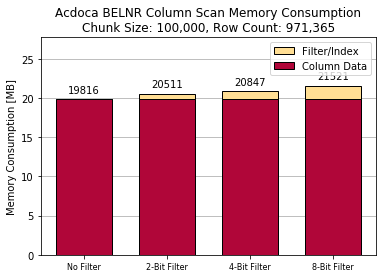

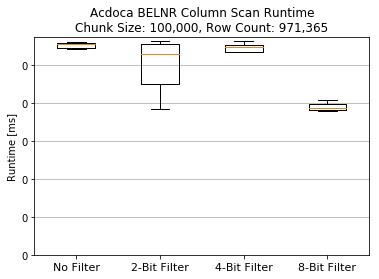

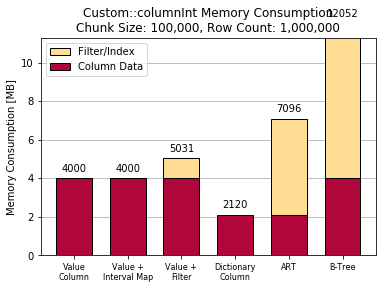

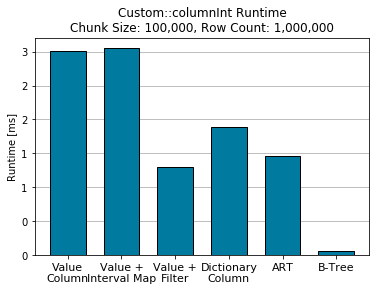

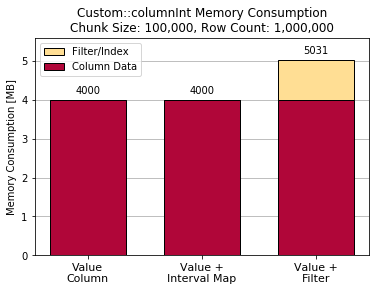

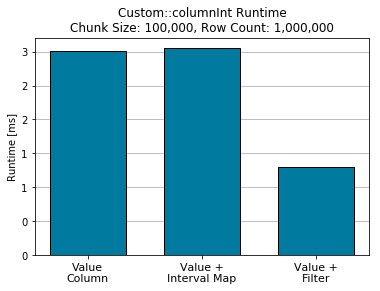

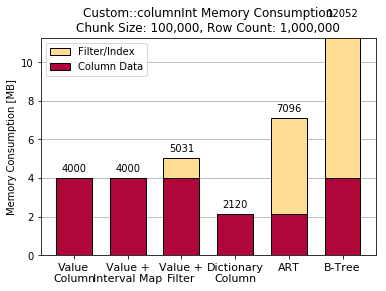

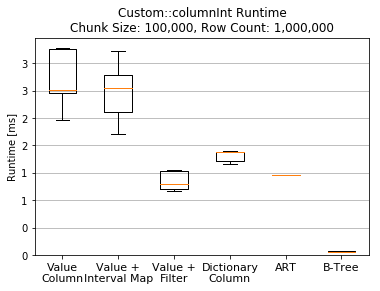

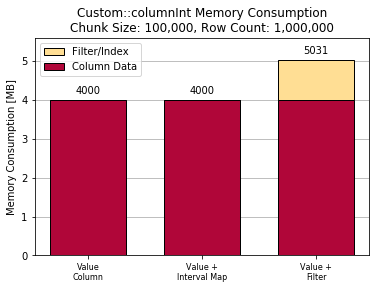

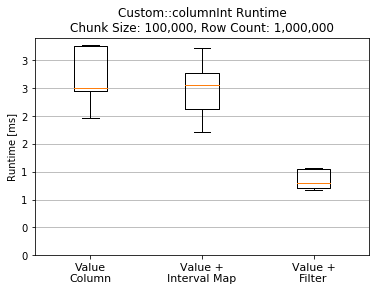

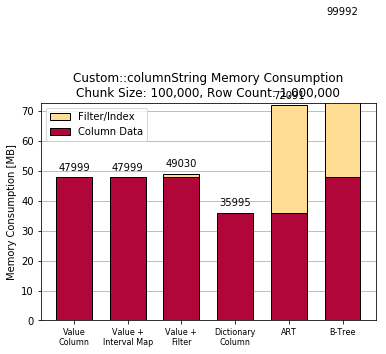

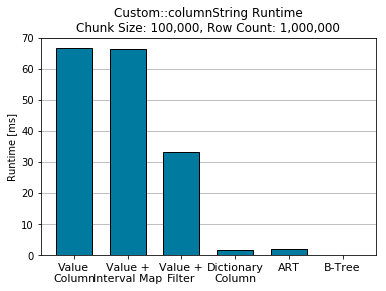

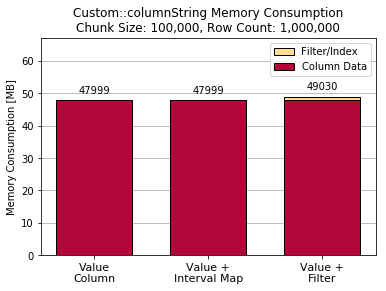

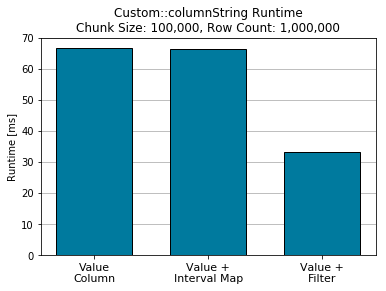

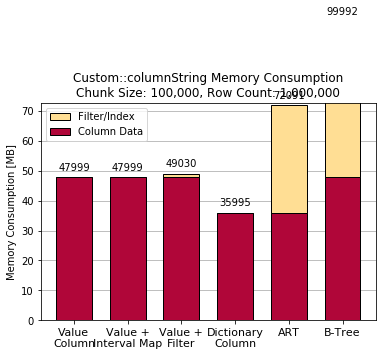

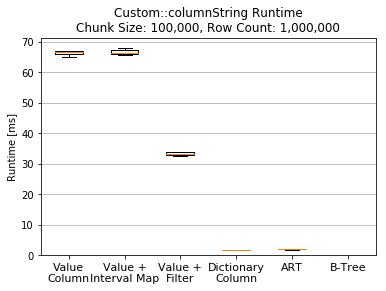

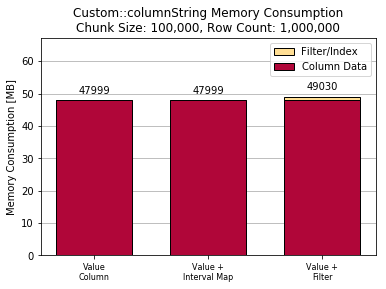

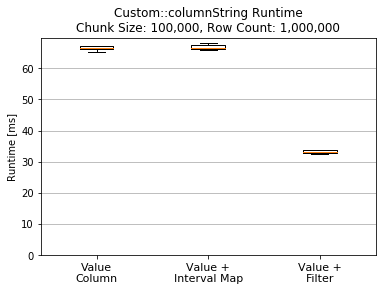

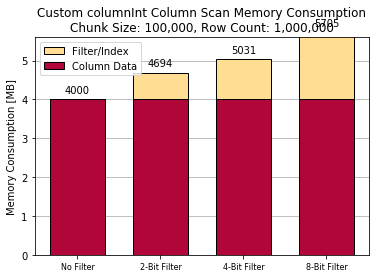

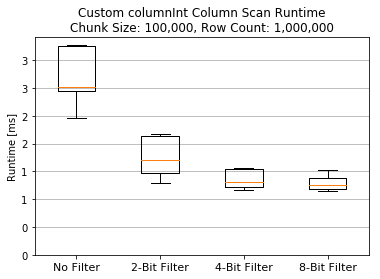

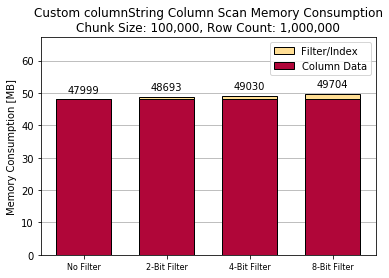

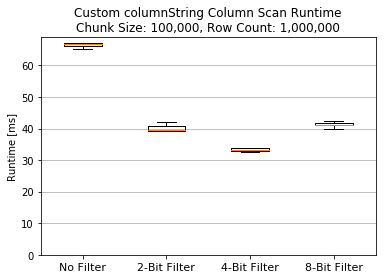

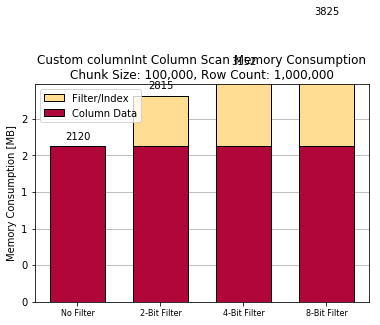

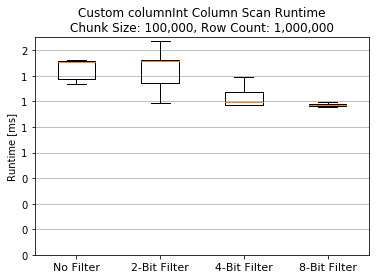

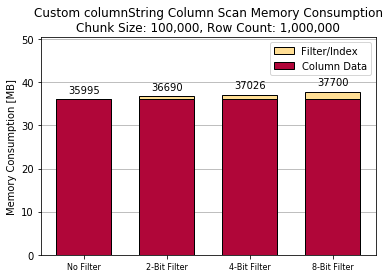

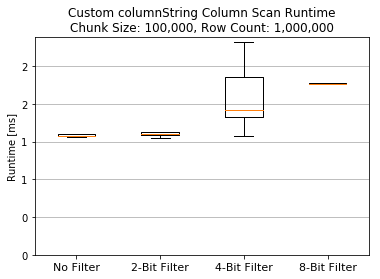

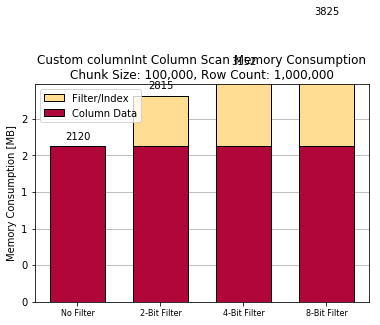

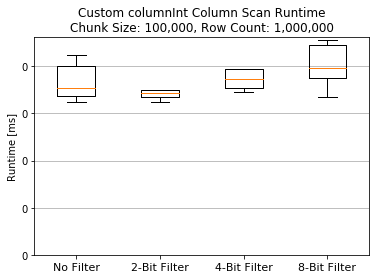

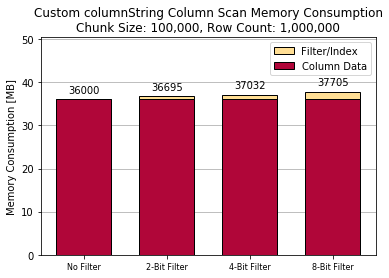

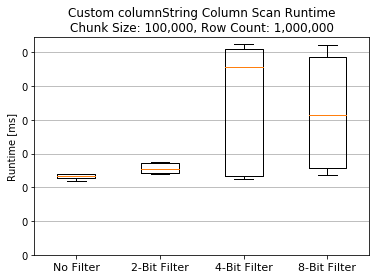

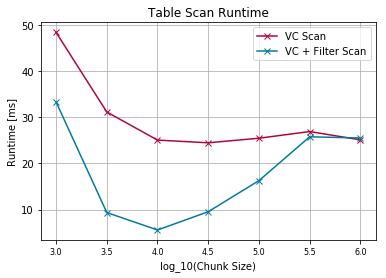

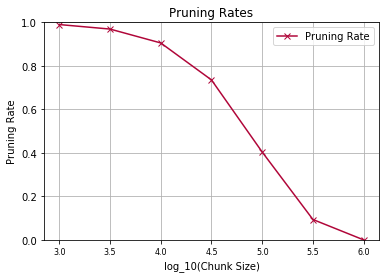

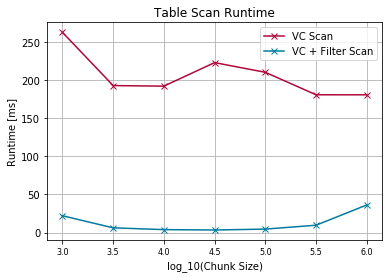

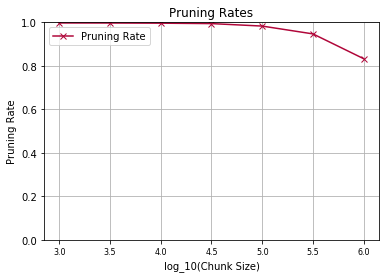

In [15]:
# Generate all plots
data_columns = [("jcch", "L_PARTKEY"), ("jcch", "L_SHIPDATE"), ("tpcc", "OL_I_ID"), ("tpcc", "OL_O_ID"), ("acdoca", "RBUKRS"), ("acdoca", "BELNR")]
for (data_name, column_name) in data_columns: 
    data = get_results(data_name)
    evaluate_bar(data_name, data, column_name)
    evaluate_box(data_name, data, column_name)
    filter_comparison(data_name, data, False, "")
    filter_comparison(data_name, data, True, "")

data = get_results('custom')
data = data[(data.pruning_rate == 0.5) & (data.data_type == 'int')]
evaluate_bar('custom', data)
evaluate_box('custom', data)

data = get_results('custom')
data = data[(data.pruning_rate == 0.5) & (data.data_type == 'string')]
evaluate_bar('custom', data)
evaluate_box('custom', data)

custom_data = get_results('custom')
data = custom_data[(custom_data.pruning_rate == 0.5) & (custom_data.data_type == 'int')]
filter_comparison('custom', data, False, "")

data = custom_data[(custom_data.pruning_rate == 0.5) & (custom_data.data_type == 'string')]
filter_comparison('custom', data, False, "")

data = custom_data[(custom_data.pruning_rate == 0.5) & (custom_data.data_type == 'int')]
filter_comparison('custom', data, True, "")

data = custom_data[(custom_data.pruning_rate == 0.5) & (custom_data.data_type == 'string')]
filter_comparison('custom', data, True, "")

data = custom_data[(custom_data.pruning_rate == 1.0) & (custom_data.data_type == 'int')]
filter_comparison('custom', data, True, "pruning_only")

data = custom_data[(custom_data.pruning_rate == 1.0) & (custom_data.data_type == 'string')]
filter_comparison('custom', data, True, "pruning_only")

chunk_size_comparison("tpcc", get_results("tpcc-chunk-sizes"))
chunk_size_comparison("jcch", get_results("jcch-chunk-sizes"))

[1000, 3162, 10000, 31622, 100000, 316228, 1000000]


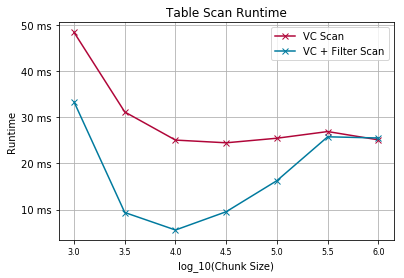

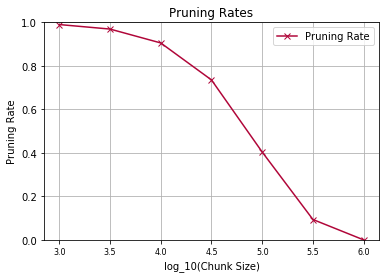

[1000, 3162, 10000, 31622, 100000, 316228, 1000000]


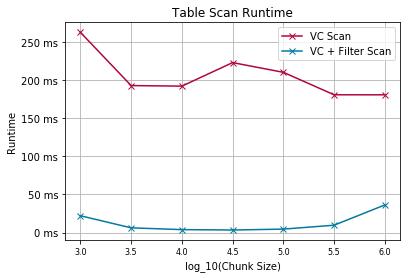

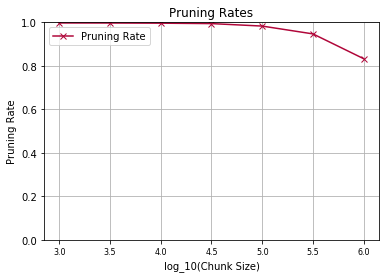

In [27]:
chunk_size_comparison("tpcc", get_results("tpcc-chunk-sizes"))
chunk_size_comparison("jcch", get_results("jcch-chunk-sizes"))